# Imports

In [42]:
import tensorflow as tf
import cv2
# from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import seaborn as sns
import os
import keras
import numpy as np
import plotly.express as px
import numpy as np


In [3]:
import keras
keras.__version__

'3.3.3'

# Dataset

# Saving to kaggle

In [4]:
import os
import json

from kaggle_secrets import UserSecretsClient
secrets = UserSecretsClient()

os.environ['KAGGLE_USERNAME'] = secrets.get_secret("KAGGLE_USERNAME")
os.environ['KAGGLE_KEY'] = secrets.get_secret("KAGGLE_KEY")

In [9]:
dataset_dir = '/kaggle/working'

In [10]:
meta = dict(
    id="ishansrivastava1308/image-map-cityscapes-19510",
    title="CityScapes Dataset",
    isPrivate=True,
    licenses=[dict(name="other")]
)

with open(os.path.join(dataset_dir,'dataset-metadata.json'), 'w') as f:
    json.dump(meta, f)
    

In [ ]:
# !kaggle datasets create -p {dataset_dir} --dir-mode zip

# Data Exploration

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import threading

def display_images_in_grid(image_paths, grid_size):
    """
    Display images in a grid.

    Parameters:
    image_paths (list): List of image file paths.
    grid_size (tuple): Number of rows and columns in the grid.
    """
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 10))
    axes = axes.flatten()
    lock = threading.Lock()
    img_arr = [None] * len(image_paths)
    def get_arr(i):
        img = mpimg.imread(image_paths[i])
        # with lock:
        img_arr[i] = img

    threads = []
    for i, img_path in enumerate(image_paths):
        th = threading.Thread(target = get_arr, args = [i])
        threads.append(th)
        th.start()
    for th in threads:
        th.join()

    # print(image_paths)

    for ax,arr in zip(axes,img_arr):
        ax.imshow(arr)
        ax.axis('off')
    # Hide remaining axes if there are fewer images than grid cells
    for ax in axes[len(image_paths):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Data Preprocessing

## Input Pipeline

In [12]:
# dataset link : https://www.kaggle.com/datasets/ishansrivastava1308/image-map-cityscapes-19510
# Add dataset to input before loading

In [13]:
gtFine_dir = '/kaggle/input/image-map-cityscapes-19510/gtFine_trainvaltest/gtFine'
leftImg8bit_dir = '/kaggle/input/image-map-cityscapes-19510/leftImg8bit_trainvaltest/leftImg8bit'

In [14]:
segment_list = [os.path.join(root, file)
            for root, dirs, files in os.walk(gtFine_dir)
            for file in files]

image_list = [os.path.join(root, file)
            for root, dirs, files in os.walk(leftImg8bit_dir)
            for file in files]

segment_list.sort()
image_list.sort()


In [15]:
output_files = [f for f in image_list if f.endswith('.png')]

In [18]:
train_x = [f for f in output_files if f.startswith(os.path.join(leftImg8bit_dir,'train'))]
val_x = [f for f in output_files if f.startswith(os.path.join(leftImg8bit_dir,'val'))]
# test_x = [f for f in output_files if f.startswith('leftImg8bit/test')]

In [19]:
train_y_label = [f for f in segment_list if f.startswith(os.path.join(gtFine_dir,'train')) and f.endswith('gtFine_labelIds.png')]
val_y_label = [f for f in segment_list if f.startswith(os.path.join(gtFine_dir,'val')) and f.endswith('gtFine_labelIds.png')]
# test_y_label = [f for f in exObj.segments.get_files_list() if f.startswith('gtFine/test') and f.endswith('gtFine_labelIds.png')]

In [20]:
train_y_color = [f for f in segment_list if f.startswith(os.path.join(gtFine_dir,'train')) and f.endswith('gtFine_color.png')]
val_y_color = [f for f in segment_list if f.startswith(os.path.join(gtFine_dir,'val')) and f.endswith('gtFine_color.png')]
# test_y_color = [f for f in exObj.segments.get_files_list() if f.startswith('gtFine/test') and f.endswith('gtFine_color.png')]

In [21]:
len(train_y_label)

2975

In [22]:
len(val_y_label)

500

# Data Preprocessor

In [23]:
import tensorflow as tf

class Preprocessor:
    def __init__(
            self,
            filepaths : list[str]
    ):
        self.filepaths = filepaths
        self.dataset = None
    def get_dataset_iterator(self,func):
        if self.dataset:
            return self.dataset

        self.dataset = tf.data.Dataset.from_tensor_slices(self.filepaths)

        self.dataset = self.dataset.map(func, num_parallel_calls=tf.data.AUTOTUNE)

        # self.dataset = self.dataset.cache()
        # self.dataset = self.dataset.shuffle(buffer_size=1000)
        # self.dataset = self.dataset.batch(32)
        # self.dataset = self.dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        return self.dataset
@tf.function
def load_preprocess_y(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, [128, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return image
    
@tf.function
def load_preprocess_x(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [128, 256])
    image = image / 255.0
    return image

In [24]:
train_ds_x = Preprocessor(train_x).get_dataset_iterator(load_preprocess_x)
val_ds_x = Preprocessor(val_x).get_dataset_iterator(load_preprocess_x)


In [25]:
train_y,val_y = train_y_label,val_y_label

In [26]:
train_ds_y = Preprocessor(train_y).get_dataset_iterator(load_preprocess_y)
val_ds_y = Preprocessor(val_y).get_dataset_iterator(load_preprocess_y)

In [27]:
dataset_train = tf.data.Dataset.zip(train_ds_x, train_ds_y)
dataset_val = tf.data.Dataset.zip(val_ds_x, val_ds_y)

In [28]:
train_ds_x.as_numpy_iterator().next().shape

(128, 256, 3)

In [29]:
def optimize_datasets(dataset):
        dataset = dataset.cache()
        dataset = dataset.shuffle(buffer_size=20)
        dataset = dataset.batch(16)
        dataset = dataset.prefetch(buffer_size=2)
        return dataset

In [30]:
dataset_train = optimize_datasets(dataset_train)
dataset_val = optimize_datasets(dataset_val)

In [31]:
temp = dataset_val.as_numpy_iterator().next()

In [32]:
x = (temp[0][1])
y = (temp[1][1])

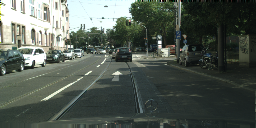

In [33]:
keras.utils.array_to_img(x)

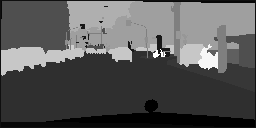

In [34]:
keras.utils.array_to_img(y)

# MODEL

In [37]:
img_x, img_y = 128,256

In [60]:
from tensorflow.keras.applications import VGG16
vgg16 = VGG16(include_top = False, input_shape = (128,256,3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [61]:
vgg16.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 128, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 128, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 128, 128)   │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 16, 512)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 16, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 16, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 16, 512)     │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
def stack_module(inp,filters):
    c_3_1 = tf.keras.layers.Conv2D(filters,3,activation = 'relu')(inp)
    c_3_2 = tf.keras.layers.Conv2D(filters,3,activation = 'relu')(c_3_1)
    c_5 = tf.keras.layers.Conv2D(filters,5,activation = 'relu')(inp)
    concat = tf.keras.layers.Concatenate()([c_5,c_3_2])
    return concat

def inverse_stack_module(inp,filters):
    c_3_1 = tf.keras.layers.Conv2DTranspose(filters,3,activation = 'relu')(inp)
    c_3_2 = tf.keras.layers.Conv2DTranspose(filters,3,activation = 'relu')(c_3_1)
    c_5 = tf.keras.layers.Conv2DTranspose(filters,5,activation = 'relu')(inp)
    concat = tf.keras.layers.Concatenate()([c_5,c_3_2])
    return concat

inp = tf.keras.Input((img_x,img_y,3))

sm1 = stack_module(inp,30) # (124,252,60)
sm2_f1 = stack_module(sm1,60) # (120,248,120)
mp1_f2 = tf.keras.layers.MaxPool2D()(sm2_f1) # (60,124,120)
c1x = tf.keras.layers.Conv2D(60,1)(mp1_f2) # (60,124,30)

sm1 = stack_module(c1x,120)  # (56,120,240)
sm2 = stack_module(sm1,120)  # (52,116,240)
mp1_f1 = tf.keras.layers.MaxPool2D()(sm2) # (26,58,240)
c1x = tf.keras.layers.Conv2D(60,1)(mp1_f1) # (26,58,30)

sm1 = stack_module(c1x,240)  # (None, 22, 54, 480)
sm2 = stack_module(sm1,240)  # (18,50,480)
mp1 = tf.keras.layers.MaxPool2D()(sm2) # (18,50,480)

c1x = tf.keras.layers.Conv2D(60,1)(sm2) # (18,50,30)

# up1 = tf.keras.layers.UpSampling2D()(mp1) # (18,50,480)
sm1 = inverse_stack_module(c1x,120)  # (None, 22, 54, 240)
sm2 = inverse_stack_module(sm1,120)  # (26,58,240)
up1 = tf.keras.layers.UpSampling2D()(sm2 + mp1_f1) # (52,116,240)

c1x = tf.keras.layers.Conv2D(60,1)(up1) # (52,116,30)
sm1 = inverse_stack_module(c1x,60)  # (None, 56, 120, 120)
sm2 = inverse_stack_module(sm1,60)  # (60,124,120)
up1 = tf.keras.layers.UpSampling2D()(sm2 + mp1_f2) # (120,248,120)

sm1 = inverse_stack_module(up1 + sm2_f1,60) # (124,252,60)
sm2 = inverse_stack_module(sm1,30) # (128,256,60)

out = tf.keras.layers.Conv2D(34,1,activation = 'softmax')(sm2)


model = tf.keras.Model(inputs = inp, outputs = out)

In [45]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 126, 254,  │        840 │ input_layer_4[0]… │
│                     │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_50 (Conv2D)  │ (None, 124, 252,  │      2,280 │ input_layer_4[0]… │
│                     │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 124, 252,  │      8,130 │ conv2d_48[0][0]   │
│                     │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_18      │ (None, 124, 252,  │          0 │ conv2d_50[0][0],  │
│ (Concatenate)       │ 60)               │            │ conv2d_49[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_51 (Conv2D)  │ (None, 122, 250,  │     32,460 │ concatenate_18[0… │
│                     │ 60)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 120, 248,  │     90,060 │ concatenate_18[0… │
│                     │ 60)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_52 (Conv2D)  │ (None, 120, 248,  │     32,460 │ conv2d_51[0][0]   │
│                     │ 60)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_19      │ (None, 120, 248,  │          0 │ conv2d_53[0][0],  │
│ (Concatenate)       │ 120)              │            │ conv2d_52[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 60, 124,   │          0 │ concatenate_19[0… │
│ (MaxPooling2D)      │ 120)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 60, 124,   │      7,260 │ max_pooling2d_6[… │
│                     │ 60)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 58, 122,   │     64,920 │ conv2d_54[0][0]   │
│                     │ 120)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 56, 120,   │    180,120 │ conv2d_54[0][0]   │
│                     │ 120)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 56, 120,   │    129,720 │ conv2d_55[0][0]   │
│                     │ 120)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_20      │ (None, 56, 120,   │          0 │ conv2d_57[0][0],  │
│ (Concatenate)       │ 240)              │            │ conv2d_56[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 54, 118,   │    259,320 │ concatenate_20[0… │
│                     │ 120)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 52, 116,   │    720,120 │ concatenate_20[0

 Total params: 9,486,154 (36.19 MB)

 Trainable params: 9,486,154 (36.19 MB)

 Non-trainable params: 0 (0.00 B)

# Metrics

In [46]:
class MeanIoU(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='mean_iou', **kwargs):
        super(MeanIoU, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.iou_class = keras.metrics.MeanIoU(num_classes=self.num_classes)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        self.iou_class.update_state(y_true=y_true, y_pred=y_pred)
        self.total_iou.assign(self.iou_class.result())

    def result(self):
        return self.total_iou

    def reset_state(self):
        self.total_iou.assign(0.0)

mean_iou = MeanIoU(34)

In [48]:
accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()

# Training

## Compiling

## Preloading

In [49]:
model.compile(
    optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = [accuracy_metric,mean_iou]
)

# Callbacks

In [50]:
import tensorflow as tf
from datetime import datetime
model_dir  = '/kaggle/working/'
log_dir = os.path.join(model_dir,"logs/fit/") + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [51]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import numpy as np

import tensorflow as tf
from sklearn.metrics import confusion_matrix
import numpy as np
import datetime

class ConfusionMatrixCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, log_dir):
        super(ConfusionMatrixCallback, self).__init__()
        self.validation_data = validation_data
        self.log_dir = log_dir
        self.writer = tf.summary.create_file_writer(self.log_dir)
        
    def on_epoch_end(self, epoch, logs=None):
        y_true_all = np.array([])
        y_pred_all = np.array([])
        for x, y_true in self.validation_data:
            y_pred = model.predict(x,verbose = 0)
            y_pred = np.argmax(y_pred, axis=-1)  # Convert one-hot predictions to labels
            y_true_all = np.concatenate((y_true_all,y_true.numpy().flatten()))
            y_pred_all = np.concatenate((y_pred_all,y_pred.flatten()))

        conf_matrix = confusion_matrix(y_true_all, y_pred_all,labels = np.arange(34))
        
        cm_image = self.plot_confusion_matrix(conf_matrix)
        
        with self.writer.as_default():
            tf.summary.image("Confusion Matrix", cm_image, step=epoch)
            
    def plot_confusion_matrix(self, cm):
        # Normalize the confusion matrix
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
        fig = plt.figure(figsize=(8, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Normalized Confusion Matrix')
        plt.colorbar()
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        
        # Convert figure to numpy array and close it
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        plt.close(fig)
        
        # Add batch dimension
        image = np.expand_dims(image, 0)
        return image
    
confusion_matrix_callback = ConfusionMatrixCallback(dataset_val,log_dir)

In [52]:
class SaveModelOnEpoch(tf.keras.callbacks.Callback):
    def __init__(self, save_path,freq = 5,offset = 0):
        super(SaveModelOnEpoch, self).__init__()
        self.save_path = save_path
        self.freq = freq
        self.offset = offset

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.freq == 0:  # Save every 5 epochs
            self.model.save(self.save_path.format(epoch=self.offset+epoch+1))
            print(f"Model saved at epoch {self.offset+epoch+1}.")
        
save_callback = SaveModelOnEpoch('/kaggle/working/Segception_b60_epoch_{epoch}.keras',offset = 0, freq = 5)

# Model Training

In [53]:
# model.fit(
#     x = dataset_train,
#     epochs = 45,
#     validation_data = dataset_val,
#     initial_epoch=40,
#     callbacks=[tensorboard_callback,save_callback],
# )

In [54]:
model = tf.keras.models.load_model('/kaggle/input/v1/keras/v1.001/5/Nineth_model.keras'),

In [55]:
x = np.array([data for data in val_ds_x.as_numpy_iterator()])
y = np.array([data for data in val_ds_y.as_numpy_iterator()])

KeyboardInterrupt: 

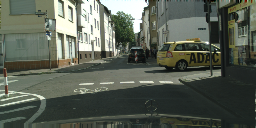

In [65]:
keras.utils.array_to_img(x[0])

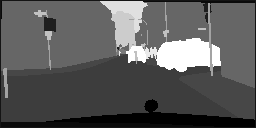

In [66]:
keras.utils.array_to_img(y[0])

In [67]:
def get_prediction(x,model):
    pred = model.predict(x)
    prediction = np.argmax(pred,axis=3,keepdims=True)
    return prediction
    

In [68]:
prediction = get_prediction(x[0:32],model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 33s 33s/step


In [69]:
print(prediction.shape)
prediction = prediction + np.zeros((32,128,256,3))
print(prediction.shape)
prediction = prediction.astype(int)

(32, 128, 256, 1)
(32, 128, 256, 3)


In [70]:
# from matplotlib.colors import ListedColormap, BoundaryNorm
cmap = np.array([(0,0,0),
 (  0,  0,  0),
(  0,  0,  0),
(  0,  0,  0),
(  0,  0,  0),
(111, 74,  0),
( 81,  0, 81),
(128, 64,128),
(244, 35,232),
(250,170,160),
(230,150,140),
( 70, 70, 70),
(102,102,156),
(190,153,153),
(180,165,180),
(150,100,100),
(150,120, 90),
(153,153,153),
(153,153,153),
(250,170, 30),
(220,220,  0),
(107,142, 35),
(152,251,152),
( 70,130,180),
(220, 20, 60),
(255,  0,  0),
(  0,  0,142),
(  0,  0, 70),
(  0, 60,100),
(  0,  0, 90),
(  0,  0,110),
(  0, 80,100),
(  0,  0,230),
(119, 11, 32),])

In [71]:

def convert_labels_to_color(arr, cmap):
    batch_size, height, width, channels = arr.shape
    arr_3_channel = arr.astype(np.float64) + np.zeros((batch_size, height, width, 3))
    reshaped_arr = arr_3_channel.reshape(-1,3)
    for i,pred in enumerate(reshaped_arr):
        idx = int(pred[0])
        if idx >= len(cmap):
            reshaped_arr[i][:] = [0.,0.,0.]
        else:
            clr = cmap[idx]
            reshaped_arr[i][:] = clr
    return reshaped_arr.reshape(batch_size, height, width, 3).astype(int)

In [72]:
colored_y = convert_labels_to_color(y[:32],cmap)
colored_pred = convert_labels_to_color(prediction,cmap)

In [88]:
def show_results(x,y,prediction,count = 16,scale = 1):
    fig,ax = plt.subplots(
        nrows = count,
        ncols = 3,
        figsize = (3 * scale, count * scale),
        gridspec_kw={
                       'width_ratios': [2,2,2],
                       'height_ratios': [1]*count,
                       'wspace': 0.1,
                       'hspace': 0.1}
    )
    ax = ax.reshape(count,3)
    print(ax.shape)
    for a,inp_img,mask_img,pred_img in zip(ax,x[:count],y[:count],prediction[:count]):
        a[0].set_title('Original image')
        a[0].imshow(inp_img)
        a[0].axis('off')
        a[1].set_title('Original mask')
        a[1].imshow(mask_img)
        a[1].axis('off')
        a[2].set_title('Predicted mask')
        a[2].imshow(pred_img)
        a[2].axis('off')
    plt.subplots_adjust(hspace=0)    
    plt.savefig('/kaggle/working/Prediction_img.jpg')
    plt.show()
    


(32, 3)


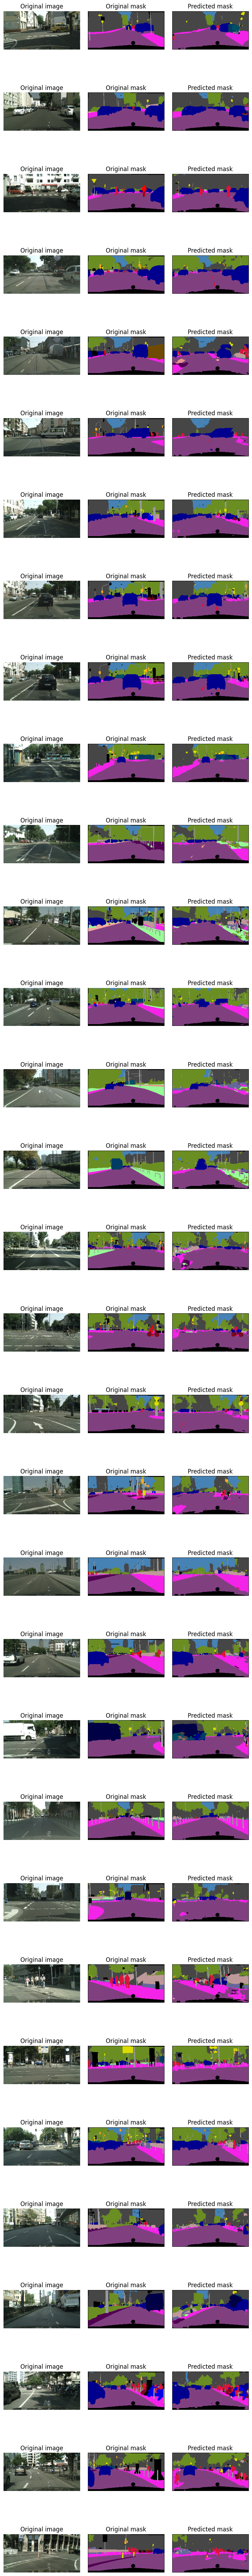

In [89]:
show_results(x[:32],colored_y,colored_pred,32,3)

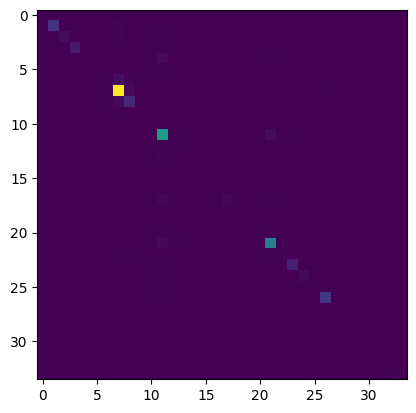

In [48]:
def get_conf_matrix(model,dataset_val):
    y_true_all = np.array([])
    y_pred_all = np.array([])
    for x, y_true in dataset_val:
        y_pred = model.predict(x,verbose = 0)
        y_pred = np.argmax(y_pred, axis=-1)  # Convert one-hot predictions to labels
        y_true_all = np.concatenate((y_true_all,y_true.numpy().flatten()))
        y_pred_all = np.concatenate((y_pred_all,y_pred.flatten()))

    conf_matrix = confusion_matrix(y_true_all, y_pred_all,labels = np.arange(34))
    plt.imshow(conf_matrix)
    return conf_matrix
conf_matrix = get_conf_matrix(benchmark_model,dataset_val)

In [ ]:
plt.imshow(conf_matrix)

In [66]:
normalized_confusion_matrix = conf_matrix.astype(np.float64) / conf_matrix.sum(axis=1)[:, np.newaxis]

/tmp/ipykernel_34/163854393.py:1: RuntimeWarning: invalid value encountered in divide
  normalized_confusion_matrix = conf_matrix.astype(np.float64) / conf_matrix.sum(axis=1)[:, np.newaxis]


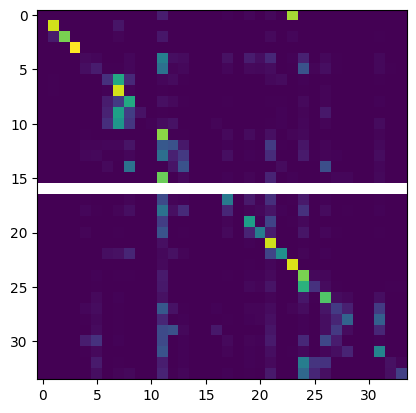

In [67]:
plt.imshow(normalized_confusion_matrix)